In [106]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\simon\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['bar']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [108]:
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [109]:
import torch
from torch import nn
from torch.utils import data as ptdata

In [110]:
import data
from utils import standard_train_step, reset_seed, smooth_plot, l2_regularization, Flatten, evaluate_net
from functional import make_functional, functional_mod_fw, fw_linearize

In [111]:
device = 'cuda' if (torch.cuda.is_available()) else 'cpu'
print(device)

cuda


In [112]:
reset_seed(device)

In [115]:
dataset = 'boston'
epochs = 50
halflife = 10

In [153]:
dataset = 'mnist'
epochs = 1
halflife = 30

## Import data

In [154]:
if dataset == 'boston':
    train_loader, test_loader = data.load_boston()

In [155]:
if dataset == 'mnist':
    train_loader, test_loader = data.load_mnist()

## Define model

In [156]:
if dataset == 'boston':
    def init_nn():
        return nn.Sequential(
            nn.Linear(13, 30),
            nn.ReLU(),
            nn.Linear(30, 1)
        )
    loss = nn.MSELoss()
    test_metric = nn.MSELoss(reduction='sum')
    l2_lambda = 1e-3

In [157]:
if dataset == 'mnist':
    def init_nn():
        return nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(20, 20, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            Flatten(),
            nn.Linear(180, 10),
            nn.LogSoftmax(dim=1)
        )
    loss = nn.NLLLoss()
    test_metric = lambda ytrue, ypred: (ytrue.eq(torch.argmax(ypred, dim=1))).sum()
    l2_lambda = 1e-3

In [158]:
net = init_nn()

In [159]:
torch.save(net.state_dict(), 'temporary.pt')

## Standard training

In [160]:
net = init_nn().to(device)
net.load_state_dict(torch.load('temporary.pt'))

<All keys matched successfully>

In [161]:
opt = torch.optim.Adam(params=net.parameters(), lr=1e-3)

In [162]:
opt_iters = len(train_loader) * epochs

In [163]:
losses_adam = []
test_metrics_adam = []
bar = tqdm.trange(opt_iters)
for epoch in range(epochs):
    test_metrics_adam.append(evaluate_net(net, test_loader, test_metric, device))
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        l = standard_train_step(net, loss, opt, xb, yb, C=l2_lambda)
        losses_adam.append(l)
        bar.update()
    bar.set_postfix({'Train loss': np.mean(losses_adam[-10:])})
test_metrics_adam.append(evaluate_net(net, test_loader, test_metric, device))
bar.close()

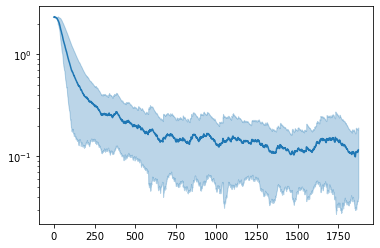

In [164]:
smooth_plot(losses_adam, halflife=halflife)
plt.yscale('log')

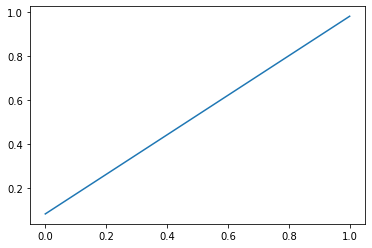

In [165]:
plt.plot(test_metrics_adam)

## SCA training

In [166]:
net = init_nn().to(device)
net.load_state_dict(torch.load('temporary.pt'))

<All keys matched successfully>

In [167]:
# Build a copy of the current parameters for inner optimization
v = []
for p in net.parameters():
    v.append(p.data.clone().detach().requires_grad_(True).to(device))

In [168]:
# Build another copy to track the gradients
d = []
for p in net.parameters():
    d.append(torch.zeros_like(p, requires_grad=False).to(device))

In [169]:
rho = 0.9
rho_eps = 0
step_size = 0.01
step_size_eps = 1e-3

In [170]:
internal_iters = 1
opt_iters = len(train_loader) * epochs

In [171]:
def sca_step(xb, yb, step_size):
        # Linearize around current point
        params, names = make_functional(net)

        net_linearized, ypred = fw_linearize(lambda *p: functional_mod_fw(xb, net, names, *p), params)

        jvp_w0 = net_linearized(params)[0]

        def surrogate_loss(v):
            jvp_v = net_linearized(v)[0]
            l = loss(ypred + jvp_v - jvp_w0, yb) + \
                    l2_regularization(v, C=l2_lambda)
            dloss = 0
            for (di, pi, vi) in zip(d, params, v):
                dloss = dloss + torch.sum(di*(pi - vi))
            return rho * l + (1 - rho) * dloss

        opt_surrogate = torch.optim.Adam(params=v, lr=1e-3)
        for _ in range(internal_iters):
            l = surrogate_loss(v)
            l.backward(retain_graph=True)
            opt_surrogate.step()
            opt_surrogate.zero_grad()

        grads = torch.autograd.grad(loss(functional_mod_fw(xb, net, names, *params), yb), params)
        for i in range(len(d)):
            d[i] = (1 - rho)*d[i] + rho*grads[i] 

        with torch.no_grad():
            for i in range(len(params)):
                _ = params[i].set_((1 - step_size)*params[i] + step_size*v[i])

        l = (loss(ypred, yb) + l2_regularization(params, C=l2_lambda)).item()
        return l

In [ ]:
losses_sca = []
test_metrics_sca = []
bar = tqdm.trange(opt_iters)
for epoch in range(epochs):
    test_metrics_sca.append(evaluate_net(net, test_loader, test_metric, device))
    
    for xb, yb in train_loader:
        
        xb, yb = xb.to(device), yb.to(device)
        l = sca_step(xb, yb, step_size)
        losses_sca.append(l)
        step_size = step_size*(1 - step_size_eps * step_size)
        bar.update()
        
    bar.set_postfix({'Train loss': np.mean(losses_sca[-10:])})
    
test_metrics_sca.append(evaluate_net(net, test_loader, test_metric, device))
bar.close()

In [ ]:
smooth_plot(losses_adam, halflife=halflife)
smooth_plot(losses_sca, halflife=halflife)
plt.yscale('log')

In [ ]:
plt.plot(test_metrics_adam, label='Adam')
plt.plot(test_metrics_sca, label='SCA')
plt.legend()